In [218]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

%config InlineBackend.figure_format = 'retina'

## Collecting Some Data

### Estimating model parameters


https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article

Serial interval: ~7 days

--------------------------------------------------------------------------------------------


https://www.nejm.org/doi/full/10.1056/NEJMoa2001316

<img src="img/serial.png" style="width: 600px;align:left"/>

The duration from illness onset to first medical visit for 45 patients with illness onset before January 1 was estimated to have a mean of 5.8 days (95% CI, 4.3 to 7.5), which was similar to that for 207 patients with illness onset between January 1 and January 11, with a mean of 4.6 days (95% CI, 4.1 to 5.1) (Figure 2C). The mean duration from onset to hospital admission was estimated to be 12.5 days (95% CI, 10.3 to 14.8) among 44 cases with illness onset before January 1, which was longer than that among 189 patients with illness onset between January 1 and 11 (mean, 9.1 days; 95% CI, 8.6 to 9.7) (Figure 2D). 

--------------------------------------------------------------------------------------------


https://jamanetwork.com/journals/jama/fullarticle/2762130

Charts from Wuhan showing date of diagnosis vs date of symptom onset.

<img src="img/wuhan.png" style="width: 600px;align:left"/>

--------------------------------------------------------------------------------------------


https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported

Days from infection to symptom onset: mean 5, most in range 3-7

Fitting the log-normal model to all cases, we estimated the median incubation period of COVID-19 to be 5.1 days (CI, 4.5 to 5.8 days) (Figure 2). We estimated that fewer than 2.5% of infected persons will show symptoms within 2.2 days (CI, 1.8 to 2.9 days) of exposure, and symptom onset will occur within 11.5 days (CI, 8.2 to 15.6 days) for 97.5% of infected persons. The estimate of the dispersion parameter was 1.52 (CI, 1.32 to 1.72), and the estimated mean incubation period was 5.5 days.

------

https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext

18 days from onset of symptoms to death


In [219]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

INFECTION_TO_SYMPTOMS = 5
SYMPTOMS_TO_DIAG = 5
SYMPTOMS_TO_DEATH = 18
CASE_DELAY = INFECTION_TO_SYMPTOMS + SYMPTOMS_TO_DIAG
DEATH_DELAY = INFECTION_TO_SYMPTOMS + SYMPTOMS_TO_DEATH

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

In [220]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    total_p = cumsum - cumsum[:, None]  # NxN matrix of total probability mass for each low, high
    lows, highs = (total_p > p).nonzero()  # all (low, high) with total probability > p
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])


def make_hdi_df(pmf, p=.9):
    hdis = highest_density_interval(pmf, p=p)
    most_likely = pmf.idxmax().rename('ML')
    # Look into why you shift -1
    return pd.concat([most_likely, hdis], axis=1)

Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

# Real-World Application to US Data

### Setup

Load US state case data from the NYT archive

In [265]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states_total = pd.read_csv(
    url,
    usecols=[0,1,2,3,4],
    index_col=['state', 'date'],
    parse_dates=['date'],
    squeeze=True
).sort_index()

state_names = [s for s in states_total.index.levels[0] if s not in FILTERED_REGIONS]

# remove filtered regions
states_total = states_total[~states_total.index.get_level_values('state').isin(FILTERED_REGIONS)]

# remove early cases that were not community spread
states_total = states_total[states_total.index.to_frame()['date'] >= '2020-03-01']



In [296]:
tests_url = "https://covidtracking.com/api/v1/states/daily.json"
states_tests = pd.read_json(
    tests_url,
    convert_dates=['date'],
)
fips_to_state = states_total.reset_index().set_index(['fips'])['state'].drop_duplicates().reset_index()

# get the full state name by joining on fips (a unique region identifier)
states_tests = states_tests.merge(
    fips_to_state,
    on='fips',
    suffixes=('_abbrev','')
).set_index(['state','date'])

state_abbrev  positive  negative  pending  \
state   date                                                 
Alaska  20200419           AK     319.0    9576.0      NaN   
        20200418           AK     314.0    9341.0      NaN   
        20200417           AK     309.0    9141.0      NaN   
        20200416           AK     300.0    8435.0      NaN   
        20200415           AK     293.0    8371.0      NaN   
...                       ...       ...       ...      ...   
Wyoming 20200311           WY       0.0       NaN      NaN   
        20200310           WY       0.0       0.0      0.0   
        20200309           WY       0.0       NaN      NaN   
        20200308           WY       0.0       NaN      NaN   
        20200307           WY       0.0       NaN      NaN   

                  hospitalizedCurrently  hospitalizedCumulative  \
state   date                                                      
Alaska  20200419                   37.0                    36.0   
        20200418                   39.0                    36.0   
        20200417                    NaN                    36.0   
        20200416                    NaN                    35.0   
        20200415                    NaN                    34.0   
...                                 ...                     ...   
Wyoming 20200311                    NaN                     NaN   
        20200310                    NaN                     NaN   
        20200309                    NaN                     NaN   
        20200308                    NaN                     NaN   
        20200307                    NaN                     NaN   

                  inIcuCurrently  inIcuCumulative  onVentilatorCurrently  \
state   date                                                               
Alaska  20200419             NaN              NaN                    NaN   
        20200418             NaN              NaN                    NaN   
        20200417             NaN              NaN                    NaN   
        20200416             NaN              NaN                    NaN   
        20200415             NaN              NaN                    NaN   
...                          ...              ...                    ...   
Wyoming 20200311             NaN              NaN                    NaN   
        20200310             NaN              NaN                    NaN   
        20200309             NaN              NaN                    NaN   
        20200308             NaN              NaN                    NaN   
        20200307             NaN              NaN                    NaN   

                  onVentilatorCumulative  ...  hospitalized   total  \
state   date                              ...                         
Alaska  20200419                     NaN  ...          36.0  9895.0   
        20200418                     NaN  ...          36.0  9655.0   
        20200417                     NaN  ...          36.0  9450.0   
        20200416                     NaN  ...          35.0  8735.0   
        20200415                     NaN  ...          34.0  8664.0   
...                                  ...  ...           ...     ...   
Wyoming 20200311                     NaN  ...           NaN     0.0   
        20200310                     NaN  ...           NaN     0.0   
        20200309                     NaN  ...           NaN     0.0   
        20200308                     NaN  ...           NaN     0.0   
        20200307                     NaN  ...           NaN     0.0   

                 totalTestResults  posNeg  fips  deathIncrease  \
state   date                                                     
Alaska  20200419           9895.0  9895.0     2            0.0   
        20200418           9655.0  9655.0     2            0.0   
        20200417           9450.0  9450.0     2            0.0   
        20200416           8735.0  8735.0     2            0.0   
        20200415           86

In [285]:
pd.merge(states_tests, fips_to_state)

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [283]:
fips_to_state

fips
1                  Alabama
2                   Alaska
4                  Arizona
5                 Arkansas
6               California
8                 Colorado
9              Connecticut
10                Delaware
11    District of Columbia
12                 Florida
13                 Georgia
15                  Hawaii
16                   Idaho
17                Illinois
18                 Indiana
19                    Iowa
20                  Kansas
21                Kentucky
22               Louisiana
23                   Maine
24                Maryland
25           Massachusetts
26                Michigan
27               Minnesota
28             Mississippi
29                Missouri
30                 Montana
31                Nebraska
32                  Nevada
33           New Hampshire
34              New Jersey
35              New Mexico
36                New York
37          North Carolina
38            North Dakota
39                    Ohio
40                Oklah

In [270]:
states_tests['fips']

0        2
1        1
2        5
3       60
4        4
        ..
2503    26
2504    44
2505    53
2506    53
2507    53
Name: fips, Length: 2508, dtype: int64

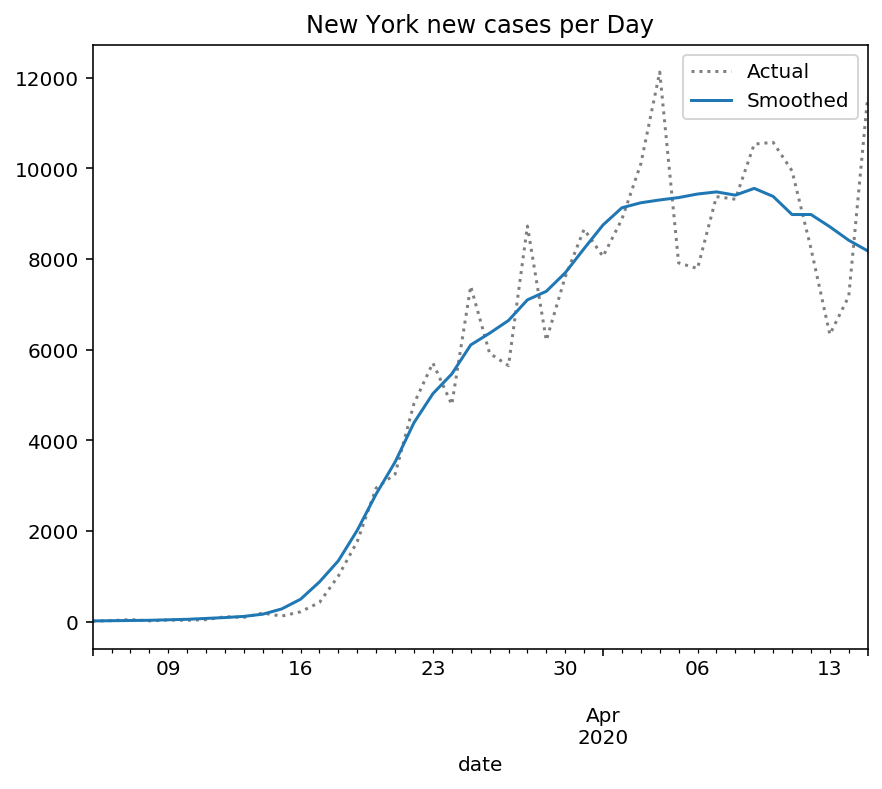

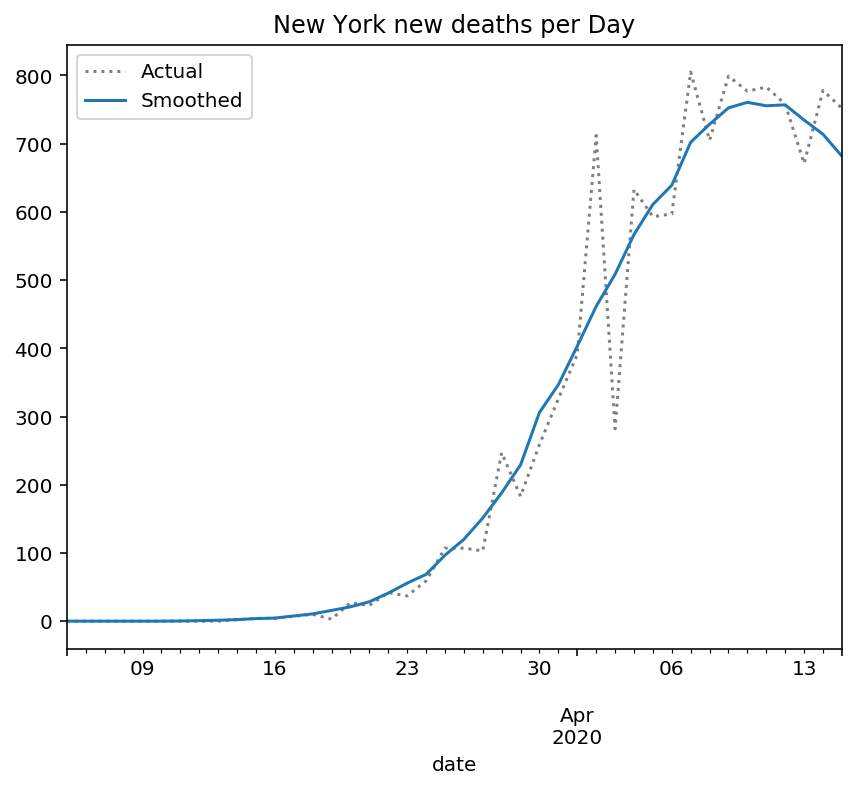

In [223]:
states = states_total.groupby("state").diff()
smoothed = states.rolling(
    7,
    win_type='gaussian',
   # min_periods=2,
    center=True
).mean(std=3).dropna()
states = states.reindex(smoothed.index)

def plot_metric(state_name, metric):
    plt.figure()
    states.loc[state_name, metric].plot(title=f"{state_name} new {metric} per Day",
                   c='k',
                   linestyle=':',
                   alpha=.5,
                   label='Actual',
                   legend=True,
                 figsize=(500/72, 400/72),
                                  )

    ax = smoothed.loc[state_name, metric].plot(label='Smoothed',
                       legend=True)

    ax.get_figure().set_facecolor('w')
    
state_name = "New York"
plot_metric(state_name, "cases")
plot_metric(state_name, "deaths")


In [234]:
def get_posteriors(sr, sigma=0.15, delay_days=0, min_count=5):
    """Get posterior R_t, given a Gaussian process update P(R_t | R_{t-1}).
    
    Arguments:
    FIXME
    """
    
    sr = sr.copy()
    sr.index = sr.index.shift(-delay_days, freq='D')
    
    # remove leading 0s
    while len(sr) > 2 and sr.iloc[0] < min_count:
        sr = sr[1:]

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values.round(), lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    # shift Rt backwards by delay_days
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed.loc['New York', 'cases'], sigma=.15)
# print(posteriors)

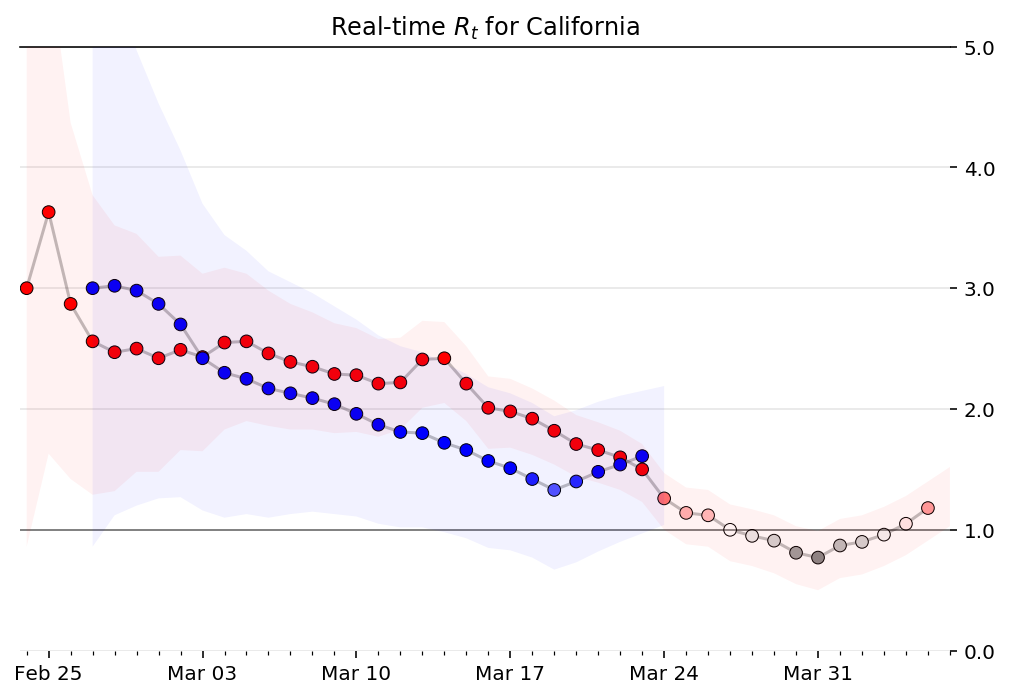

In [226]:
RED = [1, 0, 0]
BLUE = [0, 0, 1]
def plot_rt(result, ax, state_name, metric, color=RED):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = color
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2,
               label=metric)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=index[0],
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color=ABOVE,
                    alpha=.05,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    # ax.legend()
    #ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

state_name = "New York"
fig, axis = plt.subplots(2, 1, figsize=(600/72,400/72))
for metric, color, delay in zip(["cases", "deaths"], [RED, BLUE], [CASE_DELAY, DEATH_DELAY]):
    posteriors, log_likelihood = get_posteriors(smoothed.loc[state_name, metric], sigma=.15, delay_days=delay)
#     for column in posteriors.columns:
#         print(posteriors[column])
    result = make_hdi_df(posteriors)
    plot_rt(result, axis, state_name, metric, color=color)

    axis.set_title(f'Real-time $R_t$ for {state_name}')
    axis.xaxis.set_major_locator(mdates.WeekdayLocator())
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))



### Choosing the optimal $\sigma$

In the previous section we described choosing an optimal $\sigma$, but we just assumed a value. But now that we can evaluate each state with any sigma, we have the tools for choosing the optimal $\sigma$.

Above we said we'd choose the value of $\sigma$ that maximizes the likelihood of the data $P(k)$. Since we don't want to overfit on any one state, we choose the sigma that maximizes $P(k)$ over every state. To do this, we add up all the log likelihoods per state for each value of sigma then choose the maximum.

> Note: this takes a while!

In [227]:
def compute_sigma_and_results(smoothed, delay):
    sigmas = np.linspace(1/20, 1/2, 10)

    results = {}

    for state_name, state_data in smoothed.groupby("state"):
        print(state_name)
        result = {}

        # Holds all posteriors with every given value of sigma
        result['posteriors'] = []

        # Holds the log likelihood across all k for each value of sigma
        result['log_likelihoods'] = []

        for sigma in sigmas:
            posteriors, log_likelihood = get_posteriors(state_data.loc[state_name], sigma=sigma)
            result['posteriors'].append(posteriors)
            result['log_likelihoods'].append(log_likelihood)

        # Store all results keyed off of state name
        results[state_name] = result
        clear_output(wait=True)
    
    
    # Each index of this array holds the total of the log likelihoods for
    # the corresponding index of the sigmas array.
    total_log_likelihoods = np.zeros_like(sigmas)

    # Loop through each state's results and add the log likelihoods to the running total.
    for state_name, result in results.items():
        total_log_likelihoods += result['log_likelihoods']

    # Select the index with the largest log likelihood total
    max_likelihood_index = total_log_likelihoods.argmax()

    # Select the value that has the highest log likelihood
    sigma = sigmas[max_likelihood_index]

    final_results = []

    for state_name, result in results.items():
        print(state_name)
        posteriors = result['posteriors'][max_likelihood_index]
        hdis_90 = highest_density_interval(posteriors, p=.9)
        hdis_50 = highest_density_interval(posteriors, p=.5)
        most_likely = posteriors.idxmax().rename('ML')
        result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
        final_results.append(result)
        clear_output(wait=True)

    final_results = pd.concat(final_results, keys=results.keys(), names=('state','date'))
        

    print('Done.')
    return final_results, sigma

Now that we have all the log likelihoods, we can sum for each value of sigma across states, graph it, then choose the maximum.

In [245]:
cases_results, cases_sigma = compute_sigma_and_results(smoothed['cases'], CASE_DELAY)
print(f"Cases sigma: {cases_sigma}")

Done.


In [ ]:
deaths_results, deaths_sigma = compute_sigma_and_results(smoothed['deaths'], DEATH_DELAY)
print(f"Deaths sigma: {deaths_sigma}")

### Plot All US States

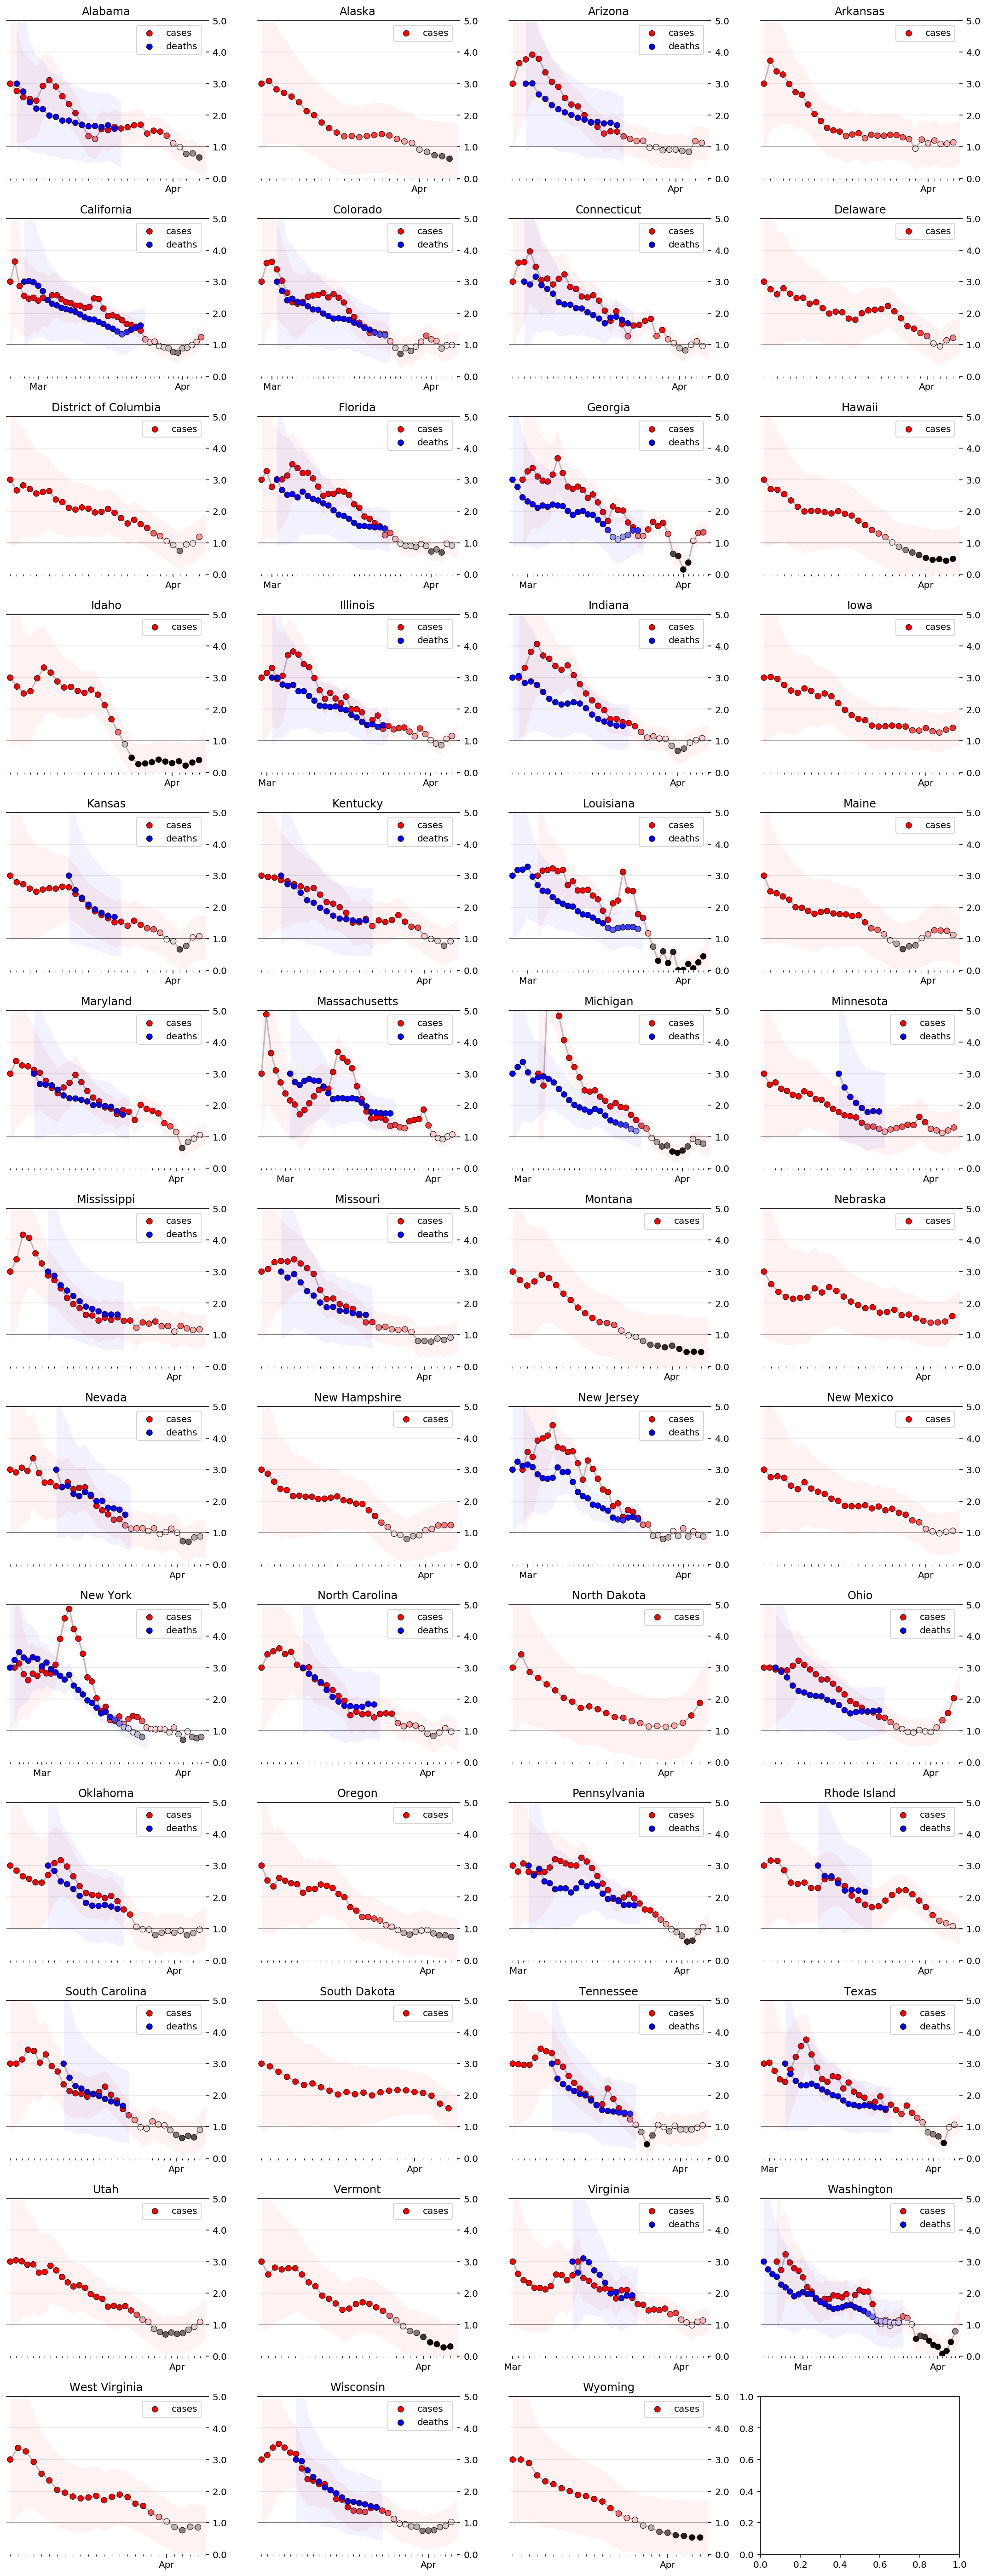

In [253]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, state_name in enumerate(state_names):
    plot_rt(cases_results.loc[state_name], axes.flat[i], state_name, metric='cases', color=RED)
    if len(deaths_results.loc[state_name]) > 5:
        plot_rt(deaths_results.loc[state_name], axes.flat[i], state_name, metric='deaths', color=BLUE)
    axes.flat[i].legend()
fig.tight_layout()
fig.set_facecolor('w')
#fig.legend()
plt.savefig("all_countries_Rt.png")

### Export Data to CSV

In [ ]:
# Uncomment the following line if you'd like to export the data
#final_results.to_csv('data/rt.csv')

### Standings

In [ ]:
# As of 4/12
no_lockdown = [
    'North Dakota',
    'South Dakota',
    'Nebraska',
    'Iowa',
    'Arkansas'
]
partial_lockdown = [
    'Utah',
    'Wyoming',
    'Oklahoma',
    'Massachusetts'
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [ ]:
final_results

In [ ]:
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

In [ ]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

In [ ]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

In [ ]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()